In [2]:
from utils import *

In [3]:
directory_path = './Data/fig14and15'
# List all files in the directory
files = [file for file in os.listdir(directory_path) if file != '.DS_Store']

In [4]:
data_dict = {}
for file in files:
    start_freq, stop_freq, cd_time, dwells, angle, distance, trail = parse_bin_name(file)
    cd = cd_time * 1e-6  # us to s
    dwell = dwells * 1e-6  # us to s
    if file not in data_dict:
        data_dict[file] = {}
    data_dict[file]['data'] = parse_csv_file(os.path.join(directory_path, file))
    data_dict[file]['angle'] = int(angle)
    data_dict[file]['cd'] = cd
    data_dict[file]['slope'] = (stop_freq - start_freq) * 1e6 / cd
    data_dict[file]['bw'] = (stop_freq - start_freq) * 1e6
    data_dict[file]['start_freq'] = start_freq

In [5]:
delta_L1 = (72 - 3) * 0.0254
delta_L2 = (72 - 48) * 0.0254
delta_L3 = (48 - 3) * 0.0254

d = 0.1

speed_ratio = 0.7453

delta_L1_inch = 72 - 3
delta_L2_inch = 72 - 48
delta_L3_inch = 48 - 3

In [6]:
plot = False
predicted_slopes = []
gt_slopes = []
gt_values = []
predicted_values = []
cali_peaks = []

gt_angles = []
predicted_peak2s = []
theory_peak_2s = []

data_slope = []

angle_w_baseband = {}

slope_w_baseband = {}

zero_sub_peak2 = []

slope_mismatch_angles = []

## 4.5GHz calibration - -1000, -1000, -2000

# Convert frequency indices to actual frequencies
l_freq = 0
r_freq = 8e4
nfft = 2**14
frequency_axis = np.linspace(l_freq, r_freq, nfft)

for key in data_dict:
    bw = data_dict[key]['bw']
    angle = data_dict[key]['angle']
    theta = np.deg2rad(float(angle))
    # Theroetical peak frequencies shift
    theta_shift = (d * np.sin(theta) / c) * data_dict[key]['slope']
    
    data = data_dict[key]['data']
    timestamp = data[:, 0]
    amplitude = data[:, 1] * 1.0
    fs = len(timestamp) / ((timestamp[-1] - timestamp[0])) # timestamps in 1us
    # Plot the data
    cd = data_dict[key]['cd']
    # if start_freq != 4.5e3:
    #     continue
    expected_period = cd + 100e-6
    theory_peak_1 = get_output_theory(delta_L1_inch, bw, cd, speed_ratio=speed_ratio)
    theory_peak_2 = get_output_theory(delta_L2_inch, bw, cd, speed_ratio=speed_ratio)
    theory_peak_3 = get_output_theory(delta_L3_inch, bw, cd, speed_ratio=speed_ratio)
    # data_dict[key]["theory_peak_2"] = theory_peak_2
    start_freq = data_dict[key]['start_freq']
    Xs, segment_indices = crop_signal_tolist(amplitude, fs, num_segments = 5, crop_factor = 8, plot = plot, window_length = 15)
    plot_data_dic = {}
    plot_data_dic["filename"] = str(angle) + "_" + key
    plot_data_dic["peak1"] = theory_peak_1 + theta_shift
    plot_data_dic["peak2"] = theory_peak_2 + 2 * theta_shift
    plot_data_dic["peak3"] = theory_peak_3 - theta_shift
    expected_ratios = [
        delta_L1 / delta_L3,  # Ratio 1 (L1 to L3)
        delta_L3 / delta_L2,   # Ratio 2 (L3 to L2)
        delta_L1 / delta_L2,   # Ratio 2 (L3 to L2)
    ]
    tolerance = 0.6  # Tolerance for ratio matching
    
    
    for index, X in enumerate(Xs):
        # Detect frequency peaks in the signal
        peaks, spectrum = detect_frequency(X, fs, plot_data_dic, signal_count = 3, plot = plot, noise_count=10)
        # peaks, spectrum = detect_frequency_spatial_smoothing(X, fs, signal_count = 3, spatial_window = 20, plot = True)
        # sub_peaks
        frequency_spectrum = spectrum 
        max_peak_value = np.max(frequency_spectrum)
        # Peak detection to find all peaks in the spectrum
        peaks, properties = signal.find_peaks(frequency_spectrum, height=max_peak_value/8)  # Adjust height threshold based on noise level
        plt.show()
        # peaks, properties = find_peaks(frequency_spectrum, height=0)  # Adjust height threshold based on noise level

        # Store valid peak triplets based on ratio matching, order, and amplitude constraint
        valid_peak_triplets = []

        # Get amplitudes of detected peaks
        peak_amplitudes = properties['peak_heights']

        # Find the largest peak amplitude in the entire spectrum
        largest_amplitude_index = np.argmax(peak_amplitudes)
        largest_peak = peaks[largest_amplitude_index]

        # Variable to store the best triplet based on amplitude sum
        best_triplet = None

        # Define the minimum distance in frequency units between peaks
        min_peak_distance = 1000
        max_amplitude_sum = 0
        # Check all combinations of three peaks for the expected ratios
        for i in range(len(peaks)):
            for j in range(i + 1, len(peaks)):
                for k in range(j + 1, len(peaks)):
                    # Enforce the order: peak[k] (L1) > peak[j] (L3) > peak[i] (L2)
                    if peaks[k] > peaks[j] > peaks[i]:
                        # Check if the peaks are too close in frequency
                        if (peaks[j] - peaks[i] < min_peak_distance) or (peaks[k] - peaks[j] < min_peak_distance) or (peaks[k] - peaks[i] < min_peak_distance):
                            continue  # Skip this triplet if any peaks are too close

                        # Calculate ratios between the three peaks
                        ratio_1 = peaks[k] / peaks[j]  # L1 to L3
                        ratio_2 = peaks[j] / (peaks[i] + 100)  # L3 to L2
                        ratio_3 = peaks[k] / (peaks[i] + 100)  # L1 to L2
                        
                        # Check if all ratios match the expected ratios within the tolerance
                        if (
                            abs(ratio_1 - expected_ratios[0]) < tolerance and
                            abs(ratio_2 - expected_ratios[1]) < tolerance and
                            abs(ratio_3 - expected_ratios[2]) < tolerance
                        ):
                            # Ensure at least one of the peaks has the largest amplitude
                            # if largest_peak in (peaks[i], peaks[j], peaks[k]):
                                # Calculate the sum of the amplitudes of the current triplet
                            amplitude_i = peak_amplitudes[np.where(peaks == peaks[i])[0][0]]
                            amplitude_j = peak_amplitudes[np.where(peaks == peaks[j])[0][0]]
                            amplitude_k = peak_amplitudes[np.where(peaks == peaks[k])[0][0]]

                            # if amplitude_k < amplitude_j or amplitude_k < amplitude_i:
                            #     continue

                            amplitude_sum = amplitude_i * amplitude_j * amplitude_k

                            # Check if this is the largest amplitude sum found so far
                            if amplitude_sum > max_amplitude_sum:
                                max_amplitude_sum = amplitude_sum
                                best_triplet = (peaks[i], peaks[j], peaks[k])
        if best_triplet:
            valid_peaks = list(best_triplet)
        else:
            valid_peaks = []  # No valid triplet found


        # Create a filtered spectrum that only contains the valid three peaks
        filtered_spectrum = np.zeros_like(frequency_spectrum)
        if len(valid_peaks) == 0:
            continue

        # Output filtered spectrum or further process
        if len(valid_peaks) != 3:
            pass
        else:
            valid_peaks = sorted(valid_peaks)
            sub_peak1 = valid_peaks[-1]
            sub_peak2 = valid_peaks[-3]
            sub_peak3 = valid_peaks[-2]
            
            # Assuming data_dict is defined somewhere else in the actual use case
            data_dict[key]["sub_peak1"] = frequency_axis[sub_peak1]
            data_dict[key]["sub_peak2"] = frequency_axis[sub_peak2]
            data_dict[key]["sub_peak3"] = frequency_axis[sub_peak3]
        
        # Plot the original and filtered spectra with actual frequencies on the x-axis
        if plot:
            plt.figure(figsize=(10, 6))
            plt.plot(frequency_axis, frequency_spectrum, label='Original Spectrum')
            plt.plot(frequency_axis, filtered_spectrum, label='Filtered Spectrum', linestyle='--')
            plt.scatter(frequency_axis[valid_peaks], frequency_spectrum[valid_peaks], color='red', label='Valid Peaks')
            plt.xlabel('Frequency (Hz)')
            plt.ylabel('Amplitude')
            plt.title('Original and Filtered Spectrum with Valid Peaks')
            plt.legend()
            plt.show()
            
        ## Estimate angles
        if "sub_peak1" not in data_dict[key]:
            continue
        sub_peak1 = data_dict[key]["sub_peak1"]
        sub_peak2 = data_dict[key]["sub_peak2"]
        sub_peak3 = data_dict[key]["sub_peak3"]
        
        if start_freq == 4500:
            sub_peak2 = sub_peak2 - 1000
            sub_peak1 = sub_peak1 - 1000
            sub_peak3 = sub_peak3 - 1000
        else:
            sub_peak2 = sub_peak2 + 1300

        
        gt_slope = bw / data_dict[key]['cd']

        
        predicted_slope = (sub_peak1 + sub_peak3) / ((delta_L1 + delta_L3) / (speed_ratio * c))
            
        predicted_slopes.append(predicted_slope)
        gt_slopes.append(gt_slope)
        
        theta1 = np.rad2deg(np.arcsin(((sub_peak1 * c) / predicted_slope - (delta_L1 / speed_ratio)) / d))
        
        theta3 = np.rad2deg(np.arcsin(((sub_peak3 * c) / predicted_slope + (delta_L3 / speed_ratio)) / d))
        
        theta2 = np.rad2deg(np.arcsin(((sub_peak2 * c) / predicted_slope - (delta_L2 / speed_ratio)) / (2*d)))
        gt_values.append(angle)
        predicted_values.append(theta2)
        
        if start_freq not in angle_w_baseband:
            angle_w_baseband[start_freq] = {}
        if angle not in angle_w_baseband[start_freq]:
            angle_w_baseband[start_freq][angle] = []
        angle_w_baseband[start_freq][angle].append(theta2)
        
        
        if start_freq not in slope_w_baseband:
            slope_w_baseband[start_freq] = {}
        if gt_slope not in slope_w_baseband[start_freq]:
            slope_w_baseband[start_freq][gt_slope] = []
        percentage_error = (np.abs(predicted_slope - gt_slope) / gt_slope) * 100
        slope_w_baseband[start_freq][gt_slope].append(percentage_error)


/var/folders/b8/hkb_33g56ysdqtzxhgm3bg640000gn/T/ipykernel_51687/2524646793.py:192: RuntimeWarning: invalid value encountered in arcsin
  theta3 = np.rad2deg(np.arcsin(((sub_peak3 * c) / predicted_slope + (delta_L3 / speed_ratio)) / d))
/var/folders/b8/hkb_33g56ysdqtzxhgm3bg640000gn/T/ipykernel_51687/2524646793.py:194: RuntimeWarning: invalid value encountered in arcsin
  theta2 = np.rad2deg(np.arcsin(((sub_peak2 * c) / predicted_slope - (delta_L2 / speed_ratio)) / (2*d)))
/var/folders/b8/hkb_33g56ysdqtzxhgm3bg640000gn/T/ipykernel_51687/2524646793.py:190: RuntimeWarning: invalid value encountered in arcsin
  theta1 = np.rad2deg(np.arcsin(((sub_peak1 * c) / predicted_slope - (delta_L1 / speed_ratio)) / d))


In [7]:
per_bb_angle_error = {}
for start_freq in angle_w_baseband:
    print(start_freq)
    if start_freq not in per_bb_angle_error:
        per_bb_angle_error[start_freq] = {}
    for angle in angle_w_baseband[start_freq]:
        errors = []
        for predicted_angle in angle_w_baseband[start_freq][angle]:
            error = abs(angle - predicted_angle)
            errors.append(error)
        if angle not in per_bb_angle_error[start_freq]:
            per_bb_angle_error[start_freq][angle] = np.array(errors)

4500
9000
24000


In [8]:
per_bb_slope_error = {}
for start_freq in slope_w_baseband:
    print(start_freq)
    if start_freq not in per_bb_slope_error:
        per_bb_slope_error[start_freq] = {}
    for slope in slope_w_baseband[start_freq]:
        errors = []
        for slope_error in slope_w_baseband[start_freq][slope]:
            error = slope_error
            errors.append(error)
        if slope not in per_bb_slope_error[start_freq]:
            per_bb_slope_error[start_freq][slope] = np.array(errors)

4500
9000
24000


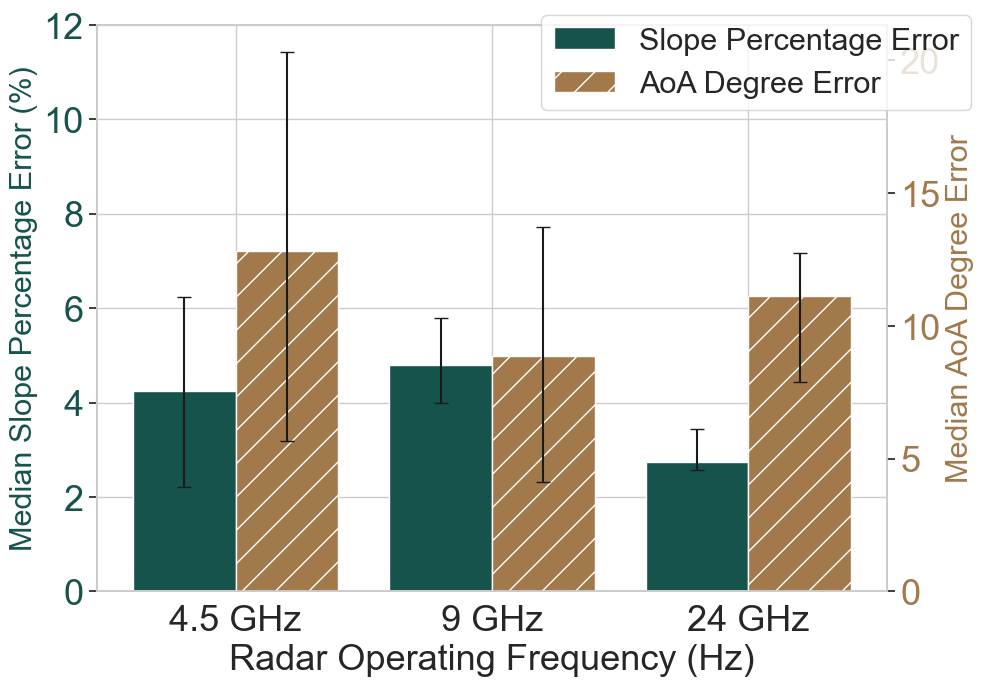

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from matplotlib.ticker import FuncFormatter

# Set seaborn style
sns.set(style="whitegrid")

# Configure fonts for publication
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# Define colors and hatches
color_map = sns.color_palette("cubehelix", 3).as_hex()
hatch_map = ['', '/', '//']

fontsize = 26
bb = ['4.5 GHz', '9 GHz', '24 GHz']

# Create a figure with one plot but two y-axes
fig, ax1 = plt.subplots(figsize=(10, 7))

# Initialize data for slope errors
slope_data = []
x_labels = []

# Sort slopes
sorted_slopes = sorted(per_bb_slope_error.keys())

# Collect slope errors and labels in sorted order
for index, slope in enumerate(sorted_slopes):
    all_errors = []
    angle_dict = per_bb_slope_error[slope]
    for angle, errors in angle_dict.items():
        # Filter out NaN values and collect all errors
        all_errors.extend(errors[~np.isnan(errors)])
    slope_data.append(all_errors)
    x_labels.append(bb[index])

# Calculate median, Q1, and Q3 for each slope
slope_medians = [np.median(errors) for errors in slope_data]
slope_q1 = [np.percentile(errors, 25) for errors in slope_data]
slope_q3 = [np.percentile(errors, 75) for errors in slope_data]

# Calculate the interquartile range for the error bars
slope_iqr_error = [np.subtract(slope_medians, slope_q1), np.subtract(slope_q3, slope_medians)]

# X positions for slope error bars (slightly offset to the left)
x_pos = np.array(range(len(slope_medians))) - 0.2

# Plot on first axis (left y-axis)
bars1 = ax1.bar(x_pos, slope_medians, width=0.4, yerr=slope_iqr_error, capsize=5, 
                align='center', color=color_map[0], hatch=hatch_map[0], label='Slope Error')
ax1.set_ylabel('Median Slope Percentage Error (%)', fontsize=fontsize-4, color=color_map[0])
ax1.tick_params(axis='y', labelsize=fontsize, labelcolor=color_map[0])
ax1.set_ylim(0, 12)

# Create second y-axis
ax2 = ax1.twinx()

# Initialize data for angle errors
angle_data = []

# Sort angles
sorted_angles = sorted(per_bb_angle_error.keys())

# Collect angle errors in sorted order
for index, slope in enumerate(sorted_angles):
    all_errors = []
    angle_dict = per_bb_angle_error[slope]
    for angle, errors in angle_dict.items():
        # Filter out NaN values and collect all errors
        all_errors.extend(errors[~np.isnan(errors)])
    angle_data.append(all_errors)

# Calculate median, Q1, and Q3 for each angle
angle_medians = [np.median(errors) for errors in angle_data]
angle_q1 = [np.percentile(errors, 25) for errors in angle_data]
angle_q3 = [np.percentile(errors, 75) for errors in angle_data]

# Calculate the interquartile range for the error bars
angle_iqr_error = [np.subtract(angle_medians, angle_q1), np.subtract(angle_q3, angle_medians)]

# X positions for angle error bars (slightly offset to the right)
x_pos2 = np.array(range(len(angle_medians))) + 0.2

# Plot on second axis (right y-axis)
bars2 = ax2.bar(x_pos2, angle_medians, width=0.4, yerr=angle_iqr_error, capsize=5, 
                align='center', color=color_map[1], hatch=hatch_map[1], label='AoA Error')
ax2.set_ylabel('Median AoA Degree Error', fontsize=fontsize-4, color=color_map[1])
ax2.tick_params(axis='y', labelsize=fontsize, labelcolor=color_map[1])

# Configure x-axis
ax1.set_xlabel('Radar Operating Frequency (Hz)', fontsize=fontsize)
ax1.set_xticks(range(len(x_labels)))
ax1.set_xticklabels(x_labels, fontsize=fontsize)
ax1.tick_params(axis='x', labelsize=fontsize)

# Add legend
fig.legend(handles=[bars1, bars2], 
           labels=['Slope Percentage Error', 'AoA Degree Error'],
           loc='upper right', 
           fontsize=fontsize-4,
           frameon=True)

# Set grid for only the left axis
ax1.grid(True)
ax2.grid(False)

# Adjust layout
plt.tight_layout()
plt.show()
